# **Importing Necessary Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras import callbacks

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# **Load the Data Set**

#### We are loading TensorFlow oxford_iiit_pet Data set and we split the train set into Train set and validation set and we keep the test set as it is.

In [3]:
#divide data set into train set as 60% val set as 20% and test set as 20%
# (ds_train, ds_val,ds_test), ds_info = tfds.load(
#     'oxford_iiit_pet',
#     split=['train+test[:20%]','test[20%:60%]', 'test[60%:]'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )
(ds_train, ds_val,ds_test), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:90%]','train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7GU9ND/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7GU9ND/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


# **Visualizing Some Data**

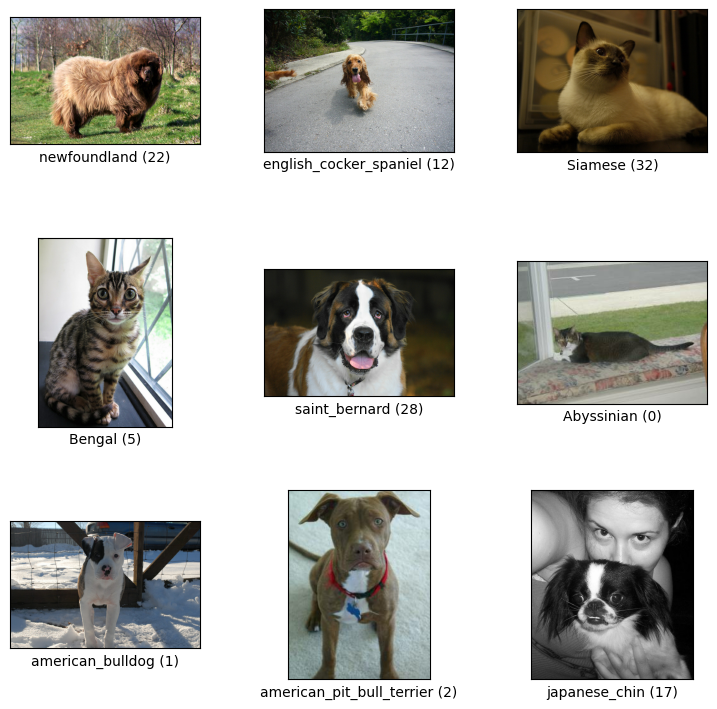

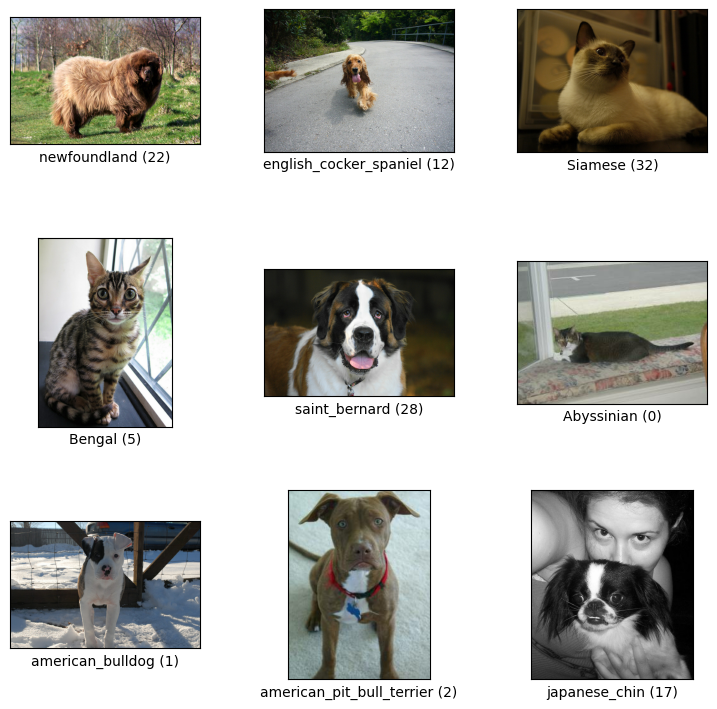

In [4]:
tfds.show_examples(ds_train, ds_info, image_key='image',label_key = 'label')

# **Number Of Classes**

In [5]:
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)


Number of classes: 37


In [6]:
num_train_examples = tf.data.experimental.cardinality(ds_train).numpy()
num_val_examples = tf.data.experimental.cardinality(ds_val).numpy()
num_test_examples = tf.data.experimental.cardinality(ds_test).numpy()

print('Number of training samples:', num_train_examples)
print('Number of val samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 3312
Number of val samples: 368
Number of test samples: 3669


# **Convert Label ID s in to Label Names**

In [7]:
get_label = ds_info.features['label'].int2str

In [8]:
print(get_label(21))

miniature_pinscher


In [9]:
def view_single_image(ds):
    image, label = next(iter(ds))
    print(label)
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label(label))

tf.Tensor(6, shape=(), dtype=int64)
Image shape:  (500, 334, 3)


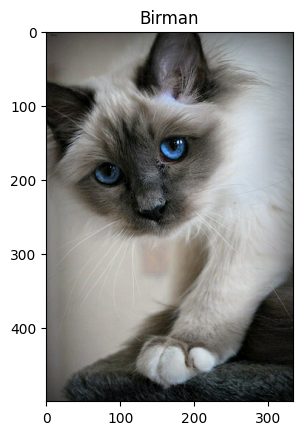

In [10]:
view_single_image(ds_train)

# **Data Augmentation**

#### The default Training data set is small compared to the test set, So we used data Augmentation to increase the size of the training data set. That could get the data set twice the size compared to the previous train set.

In [11]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
     ])

# **Resizing the images**

#### Resizing the original images into the required input size to the model, in addition to that we apply the augmentation to the data set and then concatenate those data into the train set.

In [12]:
IMG_SIZE = 299 #Input Image Size for inceptionResnet50 model

train_ds = ds_train.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y),num_parallel_calls=tf.data.AUTOTUNE)
val_ds = ds_val.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y),num_parallel_calls=tf.data.AUTOTUNE)
test_ds = ds_test.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y),num_parallel_calls=tf.data.AUTOTUNE)

train_ds_augmented=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=tf.data.AUTOTUNE)#Apply Data augmentaion and concatenate those results into train set
train_ds=train_ds.concatenate(train_ds_augmented).shuffle(1000)




In [13]:
num_train_examples = tf.data.experimental.cardinality(train_ds).numpy()
num_val_examples = tf.data.experimental.cardinality(val_ds).numpy()
num_test_examples = tf.data.experimental.cardinality(test_ds).numpy()

print('Number of training samples:', num_train_examples)
print('Number of val samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 6624
Number of val samples: 368
Number of test samples: 3669


# **One Hot Encoding**

In [14]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [15]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)


# **Defining Batch Size and Processing Data**

In [16]:
BATCH_SIZE = 64

train_ds = train_ds.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# **Loading The InceptionResenet Model**

#### Loading the InceptionResent model and initializing the weight with imagenet pre-trained weights. And also Exclude the top classifier from it.


In [17]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3),pooling="avg"
                            )

219055592/219055592 [==============================] - 8s 0us/step


# **Freezed the Base Model**

In [18]:
# Freeze the base_model
base_model.trainable = False

# **Redefining the model with the Classification Layer**


In [19]:
#redefining the model with classification layer
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = (inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)



model = keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 1536)              6144      
 atchNormalization)                                          

# **Learning Rate Schedule**

In [21]:

# return a schedule that defines a linear decay learning rate
def schedule(num_epochs):

  def schedule_function(epoch):

    return 0.01*(1 - epoch/num_epochs)

  return schedule_function

# return the callback with such schedule
def scheduler(num_epochs):

  return tf.keras.callbacks.LearningRateScheduler(schedule(num_epochs))

# **Early Stopping**

In [22]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights = True),
  ]

# **Model Compilation**

#### We used Categorical Crossentropy as the loss.

In [23]:

opt = tf.keras.optimizers.SGD(0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 1536)              6144      
 atchNormalization)                                          

# **Training Model for 10 Epochs**

In [24]:
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[get_callbacks(),scheduler(10)],
    verbose=1)

Epoch 1/10
104/104 [==============================] - 138s 1s/step - loss: 1.6557 - accuracy: 0.5859 - val_loss: 1.1701 - val_accuracy: 0.8533 - lr: 0.0100
Epoch 2/10
104/104 [==============================] - 105s 991ms/step - loss: 0.6561 - accuracy: 0.8021 - val_loss: 0.5270 - val_accuracy: 0.8859 - lr: 0.0093
Epoch 3/10
104/104 [==============================] - 105s 983ms/step - loss: 0.5223 - accuracy: 0.8361 - val_loss: 0.3660 - val_accuracy: 0.9076 - lr: 0.0087
Epoch 4/10
104/104 [==============================] - 105s 984ms/step - loss: 0.4829 - accuracy: 0.8495 - val_loss: 0.3299 - val_accuracy: 0.9076 - lr: 0.0080
Epoch 5/10
104/104 [==============================] - 107s 986ms/step - loss: 0.4301 - accuracy: 0.8587 - val_loss: 0.3157 - val_accuracy: 0.9049 - lr: 0.0073
Epoch 6/10
104/104 [==============================] - 104s 981ms/step - loss: 0.3930 - accuracy: 0.8752 - val_loss: 0.3148 - val_accuracy: 0.9049 - lr: 0.0067
Epoch 7/10
104/104 [=============================

# **Visualizing Prediction Results**

Predictions:
 [[2.15532891e-05 1.37170937e-04 2.90290336e-06 ... 6.50318805e-04
  6.61275312e-02 5.46739866e-05]
 [1.13225793e-02 5.69580197e-06 2.95214777e-05 ... 4.06506251e-06
  6.54542964e-05 2.85656442e-05]
 [7.83327505e-06 4.38133866e-04 5.11973212e-06 ... 7.19299032e-06
  6.06326648e-06 1.29957209e-06]
 ...
 [3.32013678e-06 3.82077951e-06 1.62561628e-06 ... 2.60904035e-05
  7.94280913e-06 1.41066653e-06]
 [1.00966045e-05 1.99819416e-01 4.94785123e-02 ... 3.66056561e-02
  3.31533724e-04 9.90352346e-05]
 [1.79207041e-06 2.15968998e-06 6.24391441e-06 ... 5.80643564e-06
  3.45104604e-06 1.44076366e-05]]
Labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


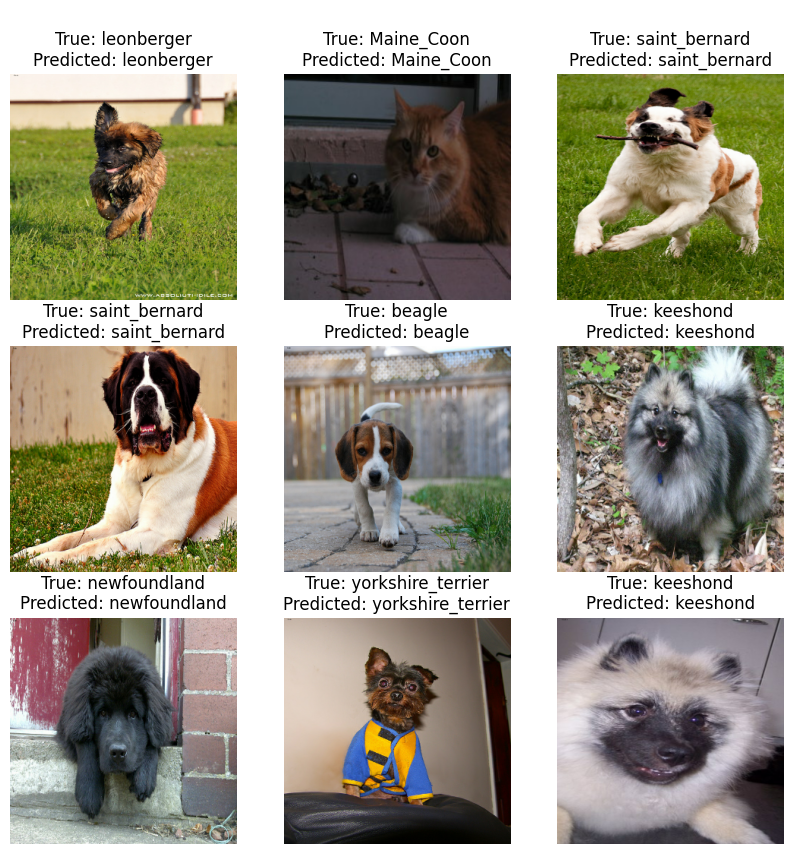

In [25]:
image_batch, label_batch = test_ds.as_numpy_iterator().next() # Retrieve a batch of images from the test set
predictions = model.predict_on_batch(image_batch)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"\nTrue: {get_label(np.argmax(label_batch[i]))}\nPredicted: {get_label(np.argmax(predictions[i]))}")
  plt.axis("off")

# **Train And Validation Accuracy Plot**

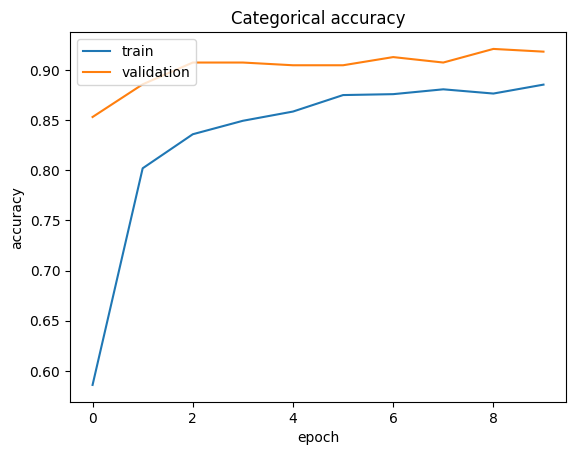

In [26]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

# **Test Set Performance**

In [27]:
result = model.evaluate(test_ds)

58/58 [==============================] - 40s 688ms/step - loss: 0.2769 - accuracy: 0.9081


In [28]:
model.save("model_inception.keras")

# **Data Augmentation Results**

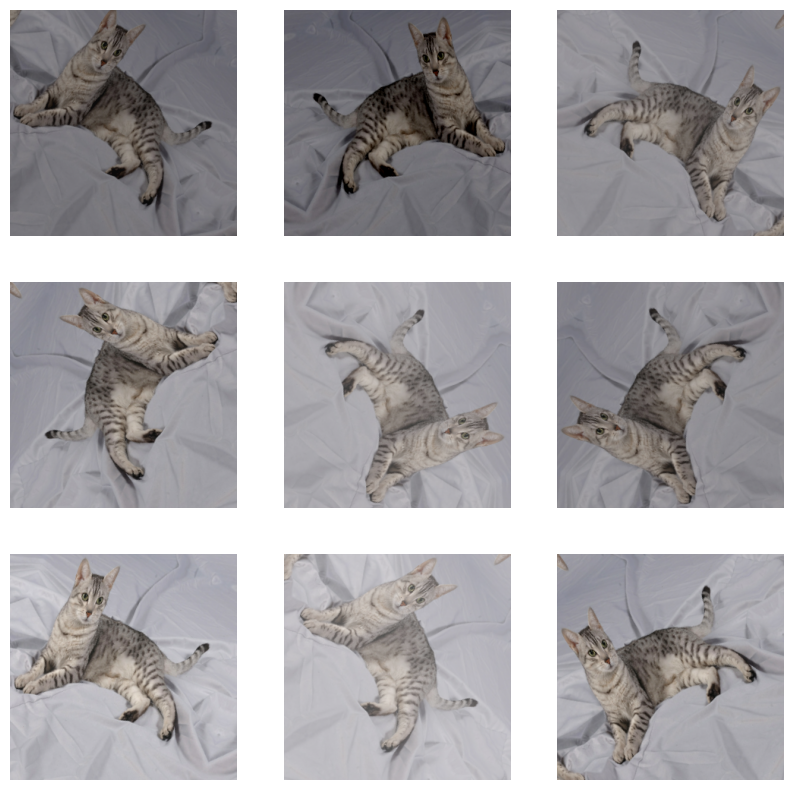

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Unfreezing the Base Model**

In [30]:
base_model.trainable=True

# **Setting Up Adam Optimizer for Fine-tuning**

#### We used Adam optimizer with 0.000001 as the learning rate, We did some experiments with different learning rates and with this low learning rate we could obtain good test accuracy

In [ ]:
def get_optimizer():
  return tf.keras.optimizers.Adam(learning_rate = 0.000001,weight_decay=0.0001)

In [32]:
model.compile(optimizer=get_optimizer(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.TopKCategoricalAccuracy( k=1, name="accuracy")]
             )
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 1536)              6144      
 atchNormalization)                                          

# **Retraining the model**

In [34]:
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
    verbose=1)

Epoch 1/10
104/104 [==============================] - 355s 2s/step - loss: 0.3308 - accuracy: 0.8936 - val_loss: 0.2755 - val_accuracy: 0.9239
Epoch 2/10
104/104 [==============================] - 254s 2s/step - loss: 0.2799 - accuracy: 0.9088 - val_loss: 0.2624 - val_accuracy: 0.9239
Epoch 3/10
104/104 [==============================] - 253s 2s/step - loss: 0.2533 - accuracy: 0.9159 - val_loss: 0.2513 - val_accuracy: 0.9293
Epoch 4/10
104/104 [==============================] - 250s 2s/step - loss: 0.2456 - accuracy: 0.9132 - val_loss: 0.2442 - val_accuracy: 0.9321
Epoch 5/10
104/104 [==============================] - 252s 2s/step - loss: 0.2264 - accuracy: 0.9232 - val_loss: 0.2344 - val_accuracy: 0.9321
Epoch 6/10
104/104 [==============================] - 251s 2s/step - loss: 0.2220 - accuracy: 0.9233 - val_loss: 0.2273 - val_accuracy: 0.9348
Epoch 7/10
104/104 [==============================] - 250s 2s/step - loss: 0.1959 - accuracy: 0.9348 - val_loss: 0.2222 - val_accuracy: 0.9375

# **Test Set Performance after Fine-Tuning**

In [35]:
result = model.evaluate(test_ds)

58/58 [==============================] - 39s 655ms/step - loss: 0.2320 - accuracy: 0.9253


# **Train and Validation Accuracies after Fine Tuning**

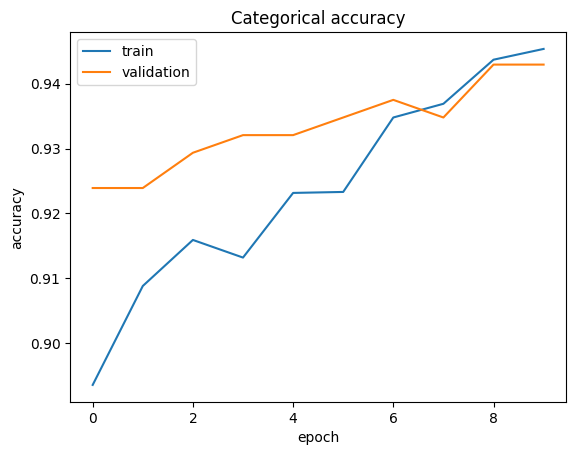

In [36]:
plot_hist(history)

In [37]:
model.save("fine_tuned_model_2_inception.keras")
reconstructed_model = keras.models.load_model("fine_tuned_model_2_inception.keras")

# **Model Prediction Results after Fine Tuning**

Predictions:
 [[5.56966173e-04 1.11316185e-05 7.33347406e-06 ... 7.52541791e-06
  1.42724684e-05 1.64023386e-05]
 [1.53025135e-03 4.42129567e-05 3.96115720e-05 ... 4.19687167e-05
  3.06659727e-04 5.96726131e-05]
 [2.60398178e-06 5.73126272e-07 1.14350496e-06 ... 3.28072542e-06
  2.90529641e-07 9.99917150e-01]
 ...
 [1.75252637e-07 1.05519041e-06 2.37603604e-06 ... 2.30658355e-08
  8.95904759e-06 3.55890847e-06]
 [4.20457727e-05 1.62011804e-06 1.59027913e-05 ... 1.75192308e-05
  4.26516272e-06 2.20904021e-05]
 [4.72676356e-06 1.13824150e-07 6.28889040e-07 ... 5.21354877e-07
  2.56334192e-06 7.76365368e-07]]
Labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


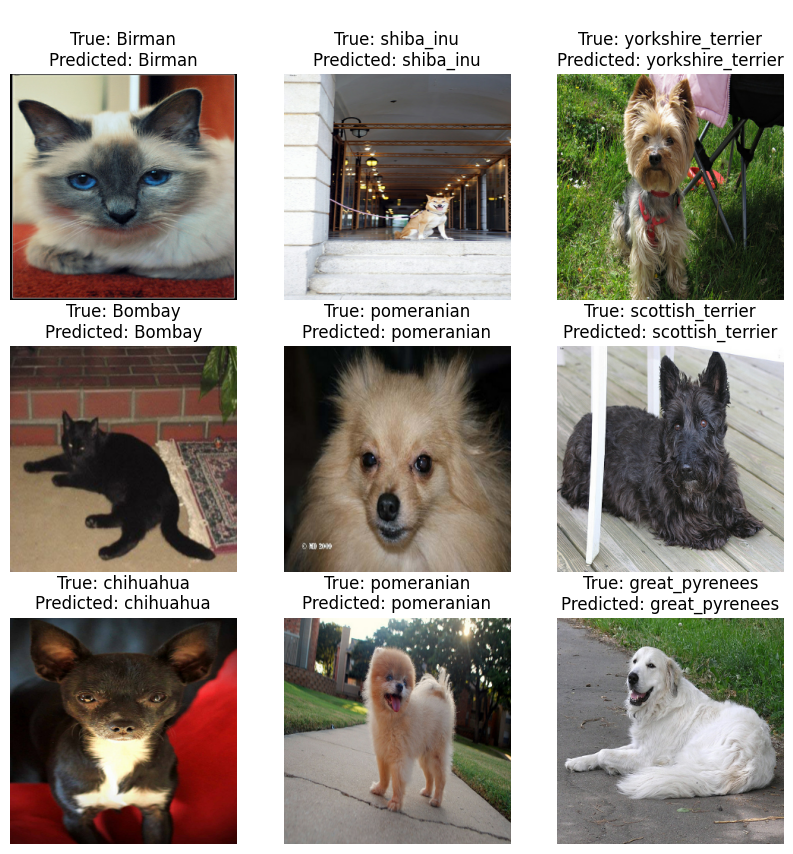

In [38]:
image_batch, label_batch = test_ds.as_numpy_iterator().next() # Retrieve a batch of images from the test set
predictions = reconstructed_model .predict_on_batch(image_batch)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"\nTrue: {get_label(np.argmax(label_batch[i]))}\nPredicted: {get_label(np.argmax(predictions[i]))}")
  plt.axis("off")

# **Conclusion**

#### We can observe that Test set performance is significantly increased after the fine tuning process. Because this is a large model it can extract more features. There is a possibility that models tend to overfit to the train set, So we use regularization to prevent Overfitting that much.